# 3: Exploration Strategies

In this notebook, we will explore the different exploration strategies that we have implemented in the `agents.exploration` module.
We have already seen the $\varepsilon$-greedy strategy in the previous notebooks, but we want to see if we can do better.
Specifically, we examine the Boltzmann (softmax) and UCB (UCB1 formula) strategies.

Because in previous experiments, we have observed that the combination of Experience Replay and the use of a target network is able to yield promising results, we will use these two techniques for all three exploration strategies.
Apart from the exploration strategies (and annealing schemes), all settings are identical to the ones found in `2_randomwarmup.ipynb`.

For both $\varepsilon$-greedy and Boltzmann, we will use the same annealing schemes as in `2_randomwarmup.ipynb`:
  - `AS1`: $\varepsilon$ (or $\tau$) is annealed from 1 to 0.01 over 80% of the training episodes.
  - `AS4`: $\varepsilon$ (or $\tau$) is annealed from 1 to 0.1 over 50% of the training episodes.

For UCB, we use a constant exploration parameter, which we call $\zeta$.
Because we have not had the time to tune this parameter, we will use a very simple value: $\zeta = 1$.

## Preliminaries

In [1]:
import os

from dql.utils.namespaces import P, LC
from dql.utils.datamanager import ConcatDataManager
from dql.utils.plotter import ColorPlot, LossPlot, ComparisonPlot

import numpy as np
import matplotlib.pyplot as plt

Check if we have the data.

Should be EG and BM for both annealing schemes, and UC for annealing scheme 0.

In [2]:
runIDs = [f for f in os.listdir(P.data) if f.startswith('EA')]
print('\n'.join(runIDs))

EA4-BM
EA1-BM
EA0-UC
EA1-EG
EA4-EG


Check if the parameters are correct.
We check for the run using the `EG` config, but it doesn't really matter which one we use; the parameters are (near-)identical for all three configs.
For the first annealing scheme, we print the full summary.

In [3]:
ConcatDataManager('EA1-EG').printSummary()

meta:
	runID: EA1-EG
	numRepetitions: 5
	numEpisodes: 20000
	runs: 5
params:
	explorationStrategy: egreedy
	annealingScheme:
		id: 1
		startVal: 1.0
		endVal: 0.01
		window: 0.8
		kind: exponential
	experienceReplay: True
	targetNetwork: True
	replayBufferSize: 100000
	targetFrequency: 1000
	alpha: 0.0010
	gamma: 0.9990
	batchSize: 512
results:
	avgRuntime: 12:20.960 min
	avgReward: 20.4101
	avgActionBias: 0.5793
	avgLoss: 1.3242


The `EA0` & `EA4` runs only differ in annealing scheme, so we load and print these separately

In [4]:
for k, v in ConcatDataManager('EA0-UC').loadSummary().params.annealingScheme.items():
    print(f'{k}: {v}')
print()
for k, v in ConcatDataManager('EA4-EG').loadSummary().params.annealingScheme.items():
    print(f'{k}: {v}')

id: 0
startVal: 1.0
endVal: 1.0
window: 0.0
kind: linear

id: 4
startVal: 1.0
endVal: 0.1
window: 0.5
kind: linear


## Plotting

Define a function to easily get all figures for a given run.

In [5]:
runNames = {'EG': f'{LC.e}-greedy', 'BM': 'Boltzmann', 'UC': 'UCB'}

def getFigs(runID: str, exp: int) -> tuple[plt.Figure]:
    expID, expName = {
        0: ('EA0', 'Annealing scheme 0'),
        1: ('EA1', 'Annealing scheme 1'),
        4: ('EA4', 'Annealing scheme 4')
    }[exp]

    title = f'| {runNames[runID]}\n{expName}'
    DM = ConcatDataManager(f'{expID}-{runID}')

    R = DM.loadRewards()
    fR = ColorPlot(R, label='reward', title=title).getFig()

    A = DM.loadActions()
    AB = np.abs((A / np.sum(A, axis=2, keepdims=True))[:, :, 0] - .5) * 2
    fAB = ColorPlot(AB, label='action bias', title=title).getFig()

    L = DM.loadLosses()
    fL = LossPlot(L, title=title).getFig()
    return fR, fAB, fL

---
### $\varepsilon$-greedy

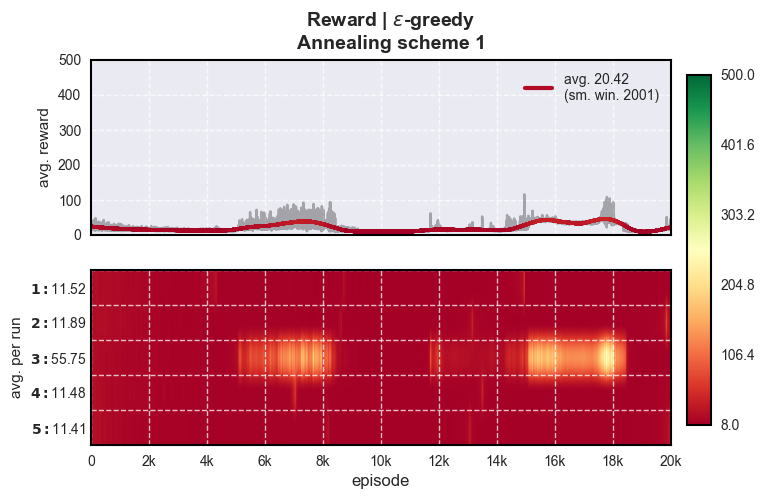

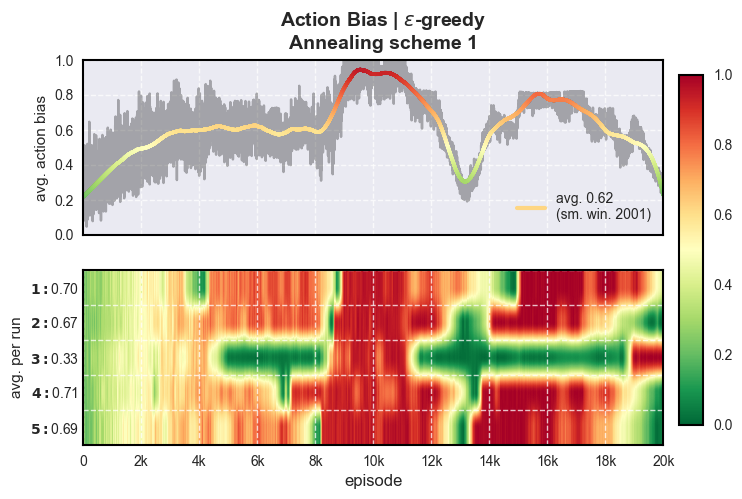

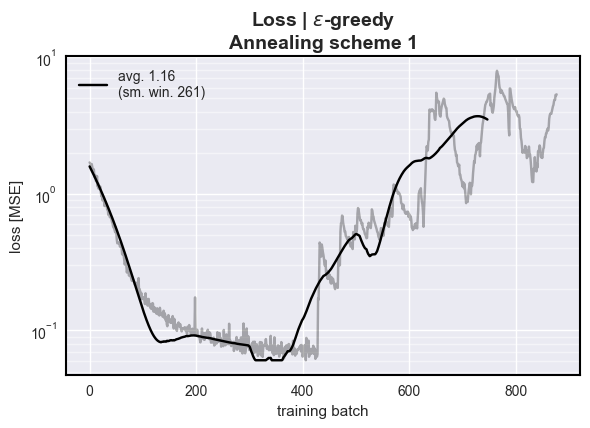

In [6]:
runID = 'EG'
rewardFig, actionBiasFig, lossFig = getFigs(runID, 1)

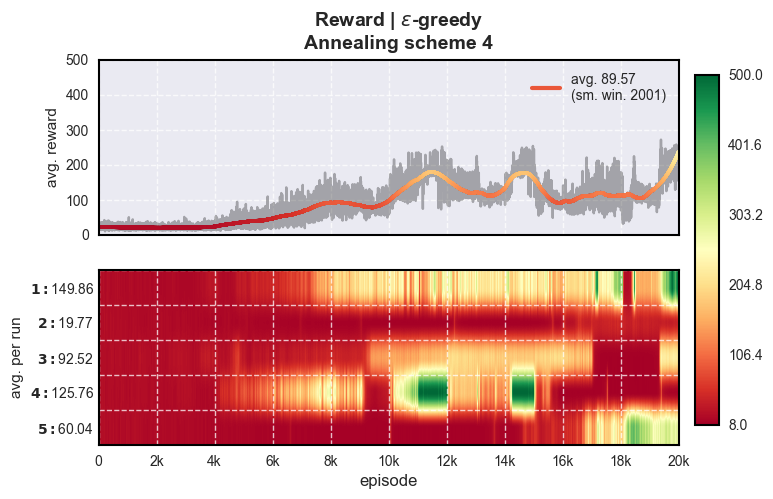

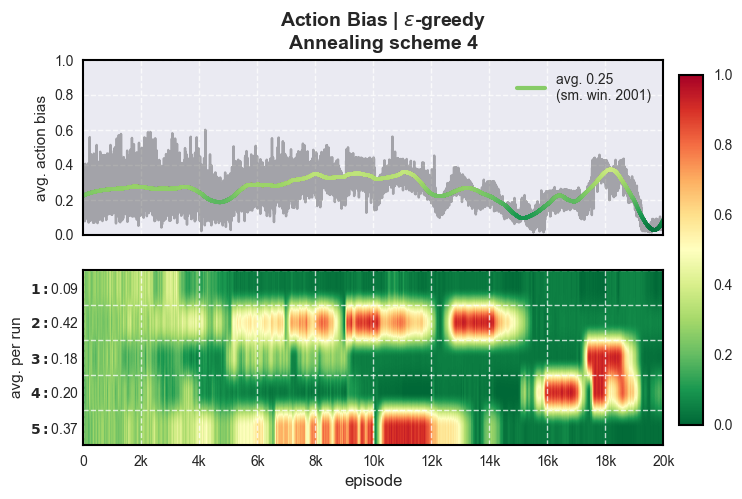

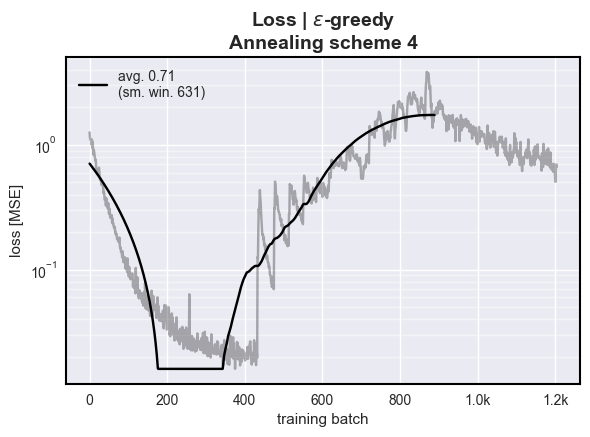

In [7]:
rewardFig, actionBiasFig, lossFig = getFigs(runID, 4)

---
### Boltzmann

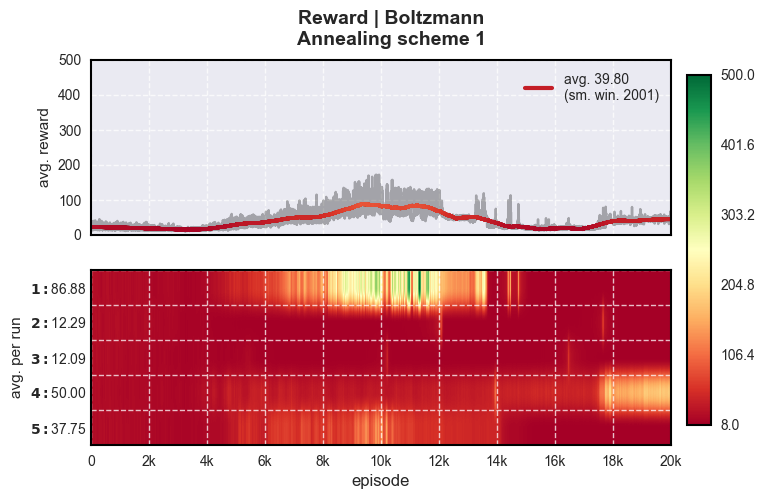

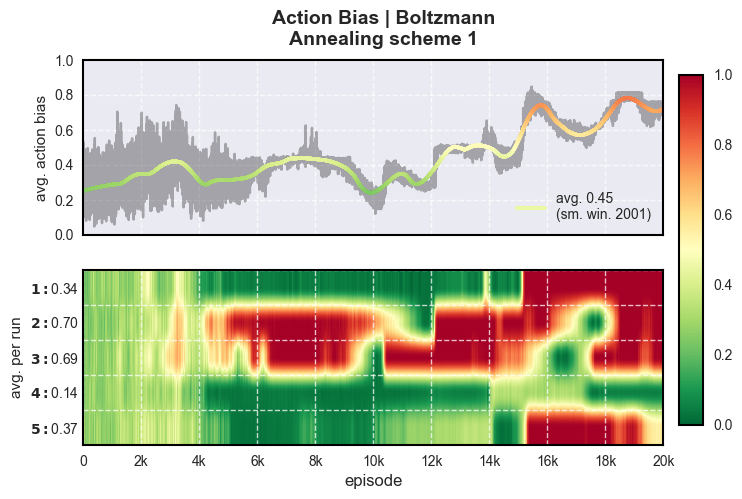

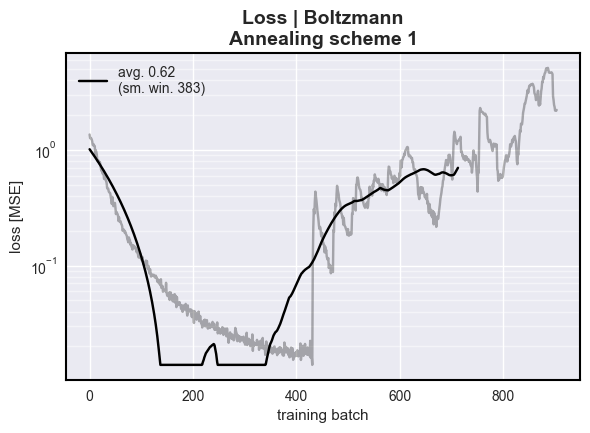

In [8]:
runID = 'BM'
rewardFig, actionBiasFig, lossFig = getFigs(runID, 1)

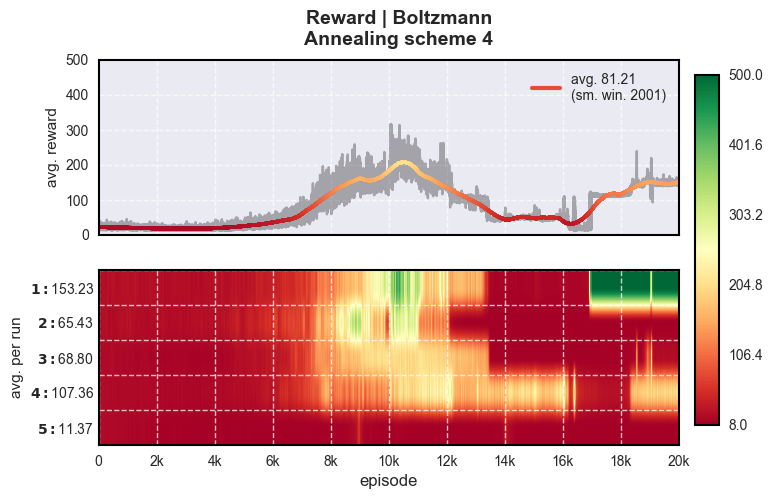

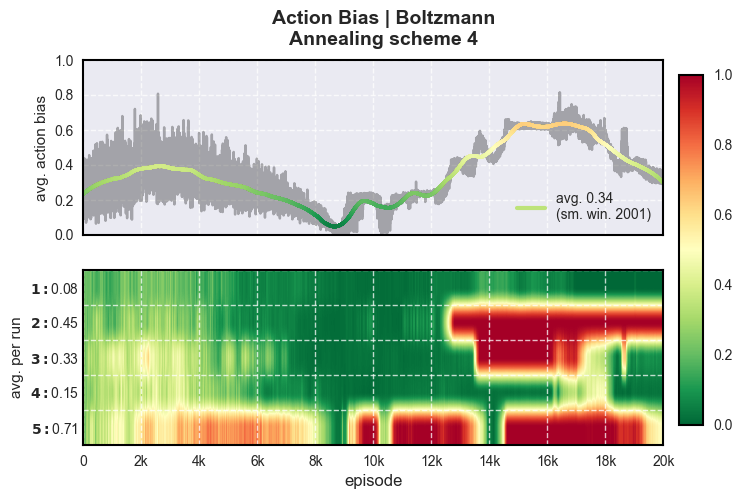

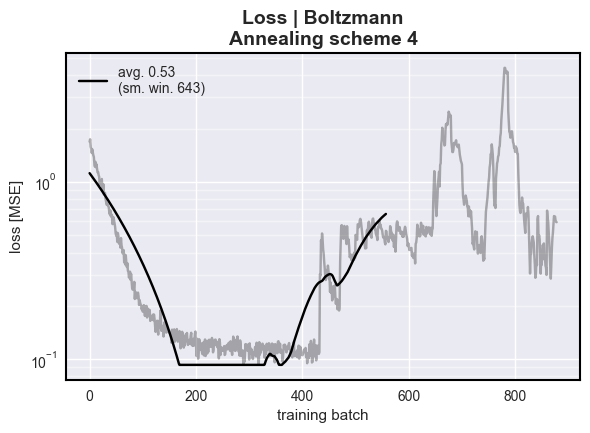

In [9]:
rewardFig, actionBiasFig, lossFig = getFigs(runID, 4)

---
### UCB

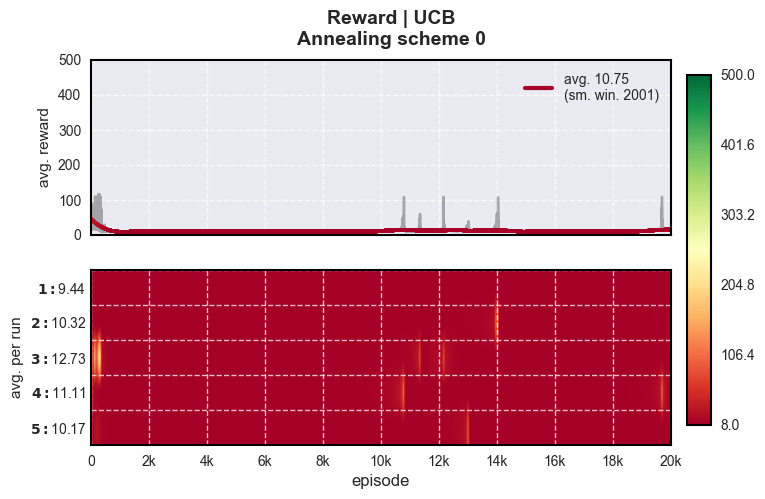

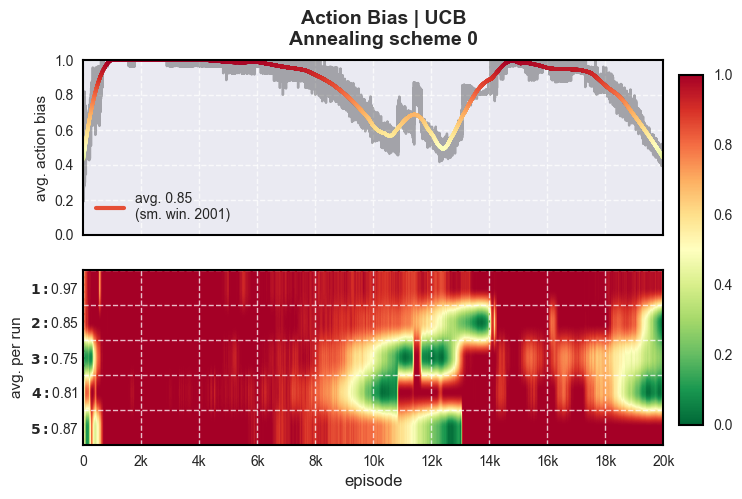

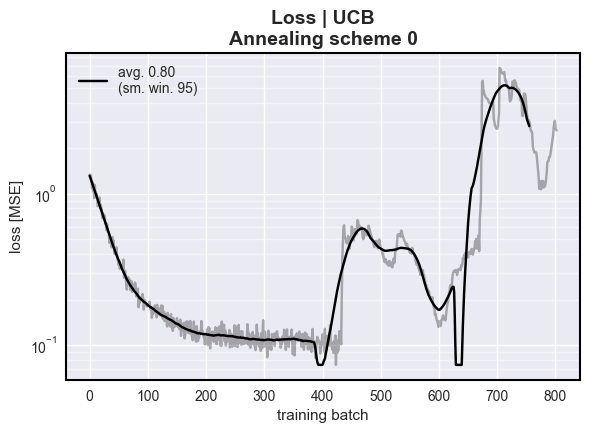

In [10]:
runID = 'UC'
rewardFig, actionBiasFig, lossFig = getFigs(runID, 0)

---
### Comparison

In [17]:
data = []
# redefine runIDS to only include EG and BM get the correct order
runIDs = ['EA1-EG', 'EA4-EG', 'EA1-BM', 'EA4-BM', 'EA0-UC']
for runID in runIDs:
    DM = ConcatDataManager(runID)
    R = DM.loadRewards()
    A = DM.loadActions()
    AB = np.abs((A / np.sum(A, axis=2, keepdims=True))[:, :, 0] - .5) * 2
    data.append((R, AB))

# uDM = ConcatDataManager('EA0-UC')
# uR = uDM.loadRewards()
# uA = uDM.loadActions()
# uAB = np.abs((uA / np.sum(uA, axis=2, keepdims=True))[:, :, 0] - .5) * 2
# data.append((uR, uAB))

In [18]:
len(data)

5

In [19]:
fig = ComparisonPlot(data, labels=runIDs, title='Exploration Strategies').getFig()

AssertionError: data and labels must have the same length